In [1]:
# импортируем библиотеки
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# загружаем данные
data_path = 'TBD'
train = pd.read_csv(data_path+'/train.csv', sep=';')
test = pd.read_csv(data_path+'/test.csv', sep=';')
test_y = pd.read_csv(data_path+'/test_answer.csv', sep=';')

In [3]:
train.head()

Store_id  SKU_id        Date  Promo  Demand  Regular_Price  Promo_Price
0         1       1  01.01.2015    NaN      22         163.78          NaN
1         1       1  02.01.2015    NaN      41         163.78          NaN
2         1       1  03.01.2015    NaN      35         163.78          NaN
3         1       1  04.01.2015    NaN      72         163.78          NaN
4         1       1  05.01.2015    NaN      25         163.78          NaN

In [4]:
test.head()

Store_id  SKU_id        Date  Promo  Demand  Regular_Price  Promo_Price
0         1       1  23.05.2016    1.0     NaN         128.98        119.6
1         1       1  24.05.2016    NaN     NaN         128.98          NaN
2         1       1  25.05.2016    NaN     NaN         131.70          NaN
3         1       1  26.05.2016    NaN     NaN         131.70          NaN
4         1       1  27.05.2016    NaN     NaN         131.70          NaN

In [5]:
test_y.head()

Store_id  SKU_id        Date  Demand
0         1       1  23.05.2016     242
1         1       1  24.05.2016      57
2         1       1  25.05.2016      63
3         1       1  26.05.2016      69
4         1       1  27.05.2016      44

In [6]:
# Дату в формат даты. В колонке Price актуальная цена.
train.Date = pd.to_datetime(train.Date, format='%d.%m.%Y')
train['Price'] = np.log(train.Regular_Price)
train.loc[train['Promo'] == 1.0,'Price'] = np.log(train.loc[train['Promo'] == 1.0,'Promo_Price']) 
# суммируем спрос по магазинам
RegionSales = train.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Price':'mean'}).reset_index()

In [7]:
train.sample(20)

Store_id  SKU_id       Date  Promo  Demand  Regular_Price  Promo_Price  \
17466        35       1 2015-07-14    NaN     352         123.55          NaN   
66155        45       2 2015-03-12    NaN       0         153.72          NaN   
38000        77       1 2015-09-05    NaN     163         133.60          NaN   
38020        77       1 2015-09-25    NaN      88         141.21          NaN   
45987         5       2 2015-08-11    NaN       3         150.73          NaN   
42404        91       1 2015-12-25    NaN      91         126.54          NaN   
45427         4       2 2015-06-20    NaN       0         134.72          NaN   
67784        48       2 2015-06-25    NaN       0         150.73          NaN   
70069        52       2 2016-03-04    NaN       0         138.36          NaN   
85963        93       2 2015-12-03    NaN       3         138.50          NaN   
25970        52       1 2015-03-04    1.0     443         151.27       135.64   
41421        86       1 2015-08-04    NaN     104         138.50          NaN   
14971        30       1 2015-08-28    NaN     198         137.68          NaN   
3332          7       1 2015-10-12    1.0     412         141.21       130.21   
75320        63       2 2015-10-06    1.0      44         143.39       122.05   
8139         17       1 2015-01-12    NaN     113         163.78          NaN   
29558        59       1 2015-04-05    NaN     399         133.33          NaN   
72069        56       2 2016-02-01    NaN       6         142.57          NaN   
61647        36       2 2015-05-15    NaN       0         150.73          NaN   
22409        45       1 2015-02-27    NaN     176         151.27          NaN   

          Price  
17466  4.816646  
66155  5.035133  
38000  4.894850  
38020  4.950248  
45987  5.015490  
42404  4.840558  
45427  4.903199  
67784  5.015490  
70069  4.929859  
85963  4.930870  
25970  4.910004  
41421  4.930870  
14971  4.924932  
3332   4.869149  
75320  4.804431  
8139   5.098524  
29558  4.892827  
72069  4.959833  
61647  5.015490  
22409  5.019066

In [32]:
RegionSales = train.groupby(['SKU_id','Date'])[['Price', 'Demand']].sum().reset_index()

In [33]:
RegionSales1 = RegionSales[RegionSales['SKU_id'] == 1]
RegionSales2 = RegionSales[RegionSales['SKU_id'] == 2]

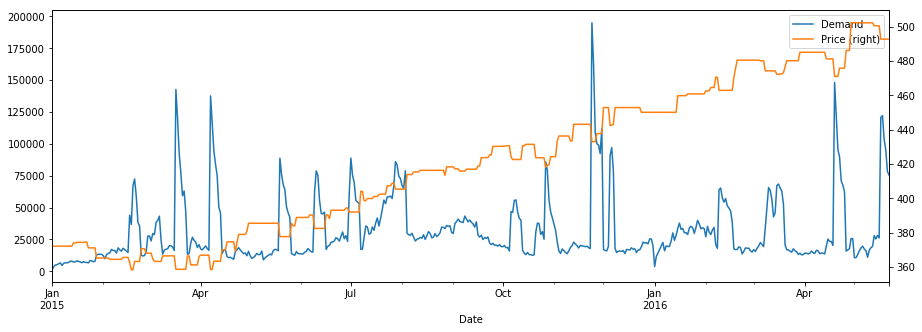

In [34]:
ax = RegionSales1.plot('Date', 'Demand', figsize=(15,5))
RegionSales1.plot('Date','Price', secondary_y=True, ax=ax)

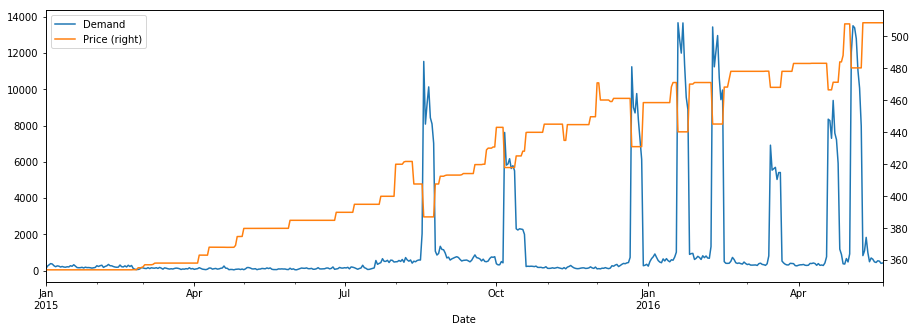

In [35]:
ax = RegionSales2.plot('Date', 'Demand', figsize=(15,5))
RegionSales2.plot('Date','Price', secondary_y=True, ax=ax)

In [12]:
# функция кросс-валидации по времени
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [36]:
# добавляем фичи
data = RegionSales.copy()

data["weekday"] = data.Date.dt.weekday
data["monthday"] = data.Date.dt.day
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

SKU_id       Date       Price  Demand  weekday  monthday  is_weekend
0       1 2015-01-01  372.235294    1180        3         1           0
1       1 2015-01-02  372.235294    3667        4         2           0
2       1 2015-01-03  372.235294    4987        5         3           1
3       1 2015-01-04  372.235294    5226        6         4           1
4       1 2015-01-05  372.235294    5951        0         5           0

In [37]:
# импортируем lightgbm
import lightgbm as lgb
lgbm = lgb.LGBMRegressor(
                        n_estimators=800,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')

In [38]:
# дату превращаем в число
data.Date = data.Date.astype(np.int64)/1000000000/3600/24

In [39]:
# разбиваем по продукту
data1 = data[data['SKU_id'] == 1].copy()
data2 = data[data['SKU_id'] == 2].copy()

In [40]:
# добавляем лаги
for i in range(1, 14):
    data1["lag_{}".format(i)] = data1.Demand.shift(i)

In [18]:
data1.head()

SKU_id     Date  Promo       Price  Demand  weekday  monthday  is_weekend  \
0       1  16436.0    0.0  372.235294    1180        3         1           0   
1       1  16437.0    0.0  372.235294    3667        4         2           0   
2       1  16438.0    0.0  372.235294    4987        5         3           1   
3       1  16439.0    0.0  372.235294    5226        6         4           1   
4       1  16440.0    0.0  372.235294    5951        0         5           0   

    lag_1   lag_2  ...   lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
0     NaN     NaN  ...     NaN    NaN    NaN    NaN    NaN    NaN     NaN   
1  1180.0     NaN  ...     NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2  3667.0  1180.0  ...     NaN    NaN    NaN    NaN    NaN    NaN     NaN   
3  4987.0  3667.0  ...     NaN    NaN    NaN    NaN    NaN    NaN     NaN   
4  5226.0  4987.0  ...  1180.0    NaN    NaN    NaN    NaN    NaN     NaN   

   lag_11  lag_12  lag_13  
0     NaN     NaN     NaN  
1     NaN     NaN     NaN  
2     NaN     NaN     NaN  
3     NaN     NaN     NaN  
4     NaN     NaN     NaN  

[5 rows x 21 columns]

In [19]:
# выделяем X и у
X_train = data1.drop(['SKU_id','Demand'], axis=1)
y_train = data1.Demand

In [20]:
# функция WAPE
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [21]:
# параметры lightgbm
kwargs = {'early_stopping_rounds':10,'verbose':2}

In [22]:
%%time
performTimeSeriesCV(X_train, y_train, 17, lgbm, wape, kwargs)
# запускаем lightgbm на трейн

Size train set: (508, 19)
Size of each fold: 29

Splitting the first 2 chunks at 1/2
Size of train + test: (58, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 10488.2
[4]	valid_0's l1: 10488.2
[6]	valid_0's l1: 10488.2
[8]	valid_0's l1: 10488.2
[10]	valid_0's l1: 10488.2
Early stopping, best iteration is:
[1]	valid_0's l1: 10488.2

Splitting the first 3 chunks at 2/3
Size of train + test: (87, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 22879
[4]	valid_0's l1: 21804.7
[6]	valid_0's l1: 20976.2
[8]	valid_0's l1: 20280.7
[10]	valid_0's l1: 19694.7
[12]	valid_0's l1: 19300.4
[14]	valid_0's l1: 19162
[16]	valid_0's l1: 18913.2
[18]	valid_0's l1: 18901.2
[20]	valid_0's l1: 18624
[22]	valid_0's l1: 18483.8
[24]	valid_0's l1: 18345.3
[26]	valid_0's l1: 18260.1
[28]	valid_0's l1: 18081.1
[30]	valid_0's l1: 18013.3
[32]	valid_0's l1: 18041.3
[34]	valid_0's l1: 18058.6
[36]	valid_0's l1: 17912.6
[38]	valid_0's l1: 17926.8


Splitting the first 14 chunks at 13/14
Size of train + test: (406, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5134.71
[4]	valid_0's l1: 4803.34
[6]	valid_0's l1: 4436.27
[8]	valid_0's l1: 4716.1
[10]	valid_0's l1: 5401.64
[12]	valid_0's l1: 5212.29
[14]	valid_0's l1: 5115.73
[16]	valid_0's l1: 5357.85
Early stopping, best iteration is:
[7]	valid_0's l1: 4434.27

Splitting the first 15 chunks at 14/15
Size of train + test: (435, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 12270.3
[4]	valid_0's l1: 9792.85
[6]	valid_0's l1: 8440.72
[8]	valid_0's l1: 7785.63
[10]	valid_0's l1: 7296.22
[12]	valid_0's l1: 6369.49
[14]	valid_0's l1: 6112.87
[16]	valid_0's l1: 6206.09
[18]	valid_0's l1: 5741.02
[20]	valid_0's l1: 5939.94
[22]	valid_0's l1: 6070.35
[24]	valid_0's l1: 5884.3
[26]	valid_0's l1: 5738.62
[28]	valid_0's l1: 5639.85
[30]	valid_0's l1: 5609.61
[32]	valid_0's l1: 5537.17
[34]	valid_0's l1: 5520.53
[36]	val

27.5281930470058

In [44]:
# объединяем трейн и тест
test.Date = pd.to_datetime(test.Date, format='%d.%m.%Y')
df = pd.concat([train, test], axis=0, sort=False, ignore_index=True)

In [45]:
df.head()

Store_id  SKU_id       Date  Promo  Demand  Regular_Price  Promo_Price  \
0         1       1 2015-01-01    NaN    22.0         163.78          NaN   
1         1       1 2015-01-02    NaN    41.0         163.78          NaN   
2         1       1 2015-01-03    NaN    35.0         163.78          NaN   
3         1       1 2015-01-04    NaN    72.0         163.78          NaN   
4         1       1 2015-01-05    NaN    25.0         163.78          NaN   

      Price  
0  5.098524  
1  5.098524  
2  5.098524  
3  5.098524  
4  5.098524

In [48]:
# add test-flag
df['test'] = 0
df.loc[df.Demand.isnull(), 'test'] = 1

In [51]:
# предобработка как в предыдущий раз
df.Date = pd.to_datetime(df.Date, format='%d.%m.%Y')
df['Price'] = np.log(df.Regular_Price)
df.loc[df['Promo'] == 1.0,'Price'] = np.log(df.loc[df['Promo'] == 1.0,'Promo_Price']) 
data = df.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Price':'mean','test':'first'}).reset_index()

In [52]:
data["weekday"] = data.Date.dt.weekday
data["monthday"] = data.Date.dt.day
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

SKU_id       Date  Demand  Promo  Store_id     Price  test  weekday  \
0       1 2015-01-01  1180.0    0.0        73  5.099114     0        3   
1       1 2015-01-02  3667.0    0.0        73  5.099114     0        4   
2       1 2015-01-03  4987.0    0.0        73  5.099114     0        5   
3       1 2015-01-04  5226.0    0.0        73  5.099114     0        6   
4       1 2015-01-05  5951.0    0.0        73  5.099114     0        0   

   monthday  is_weekend  
0         1           0  
1         2           0  
2         3           1  
3         4           1  
4         5           0

In [53]:
data.Date = data.Date.astype(np.int64)/1000000000/3600/24

In [54]:
# разбиваем на два продукта
data1 = data[data['SKU_id'] == 1].copy()
data2 = data[data['SKU_id'] == 2].copy()

In [55]:
# лаги
n_lag = 14
for i in range(1, n_lag):
    data1["lag_{}".format(i)] = data1.Demand.shift(i)
    data2["lag_{}".format(i)] = data2.Demand.shift(i)

In [56]:
data1.head()

SKU_id     Date  Demand  Promo  Store_id     Price  test  weekday  \
0       1  16436.0  1180.0    0.0        73  5.099114     0        3   
1       1  16437.0  3667.0    0.0        73  5.099114     0        4   
2       1  16438.0  4987.0    0.0        73  5.099114     0        5   
3       1  16439.0  5226.0    0.0        73  5.099114     0        6   
4       1  16440.0  5951.0    0.0        73  5.099114     0        0   

   monthday  is_weekend  ...   lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
0         1           0  ...     NaN    NaN    NaN    NaN    NaN    NaN   
1         2           0  ...     NaN    NaN    NaN    NaN    NaN    NaN   
2         3           1  ...     NaN    NaN    NaN    NaN    NaN    NaN   
3         4           1  ...     NaN    NaN    NaN    NaN    NaN    NaN   
4         5           0  ...  1180.0    NaN    NaN    NaN    NaN    NaN   

   lag_10  lag_11  lag_12  lag_13  
0     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN     NaN  

[5 rows x 23 columns]

In [57]:
# Х и у для трениировки
X_train1 = data1[data1['test'] == 0].drop(['SKU_id','Store_id','Demand','test'], axis=1)
y_train1 = data1[data1['test'] == 0].Demand
X_train2 = data2[data2['test'] == 0].drop(['SKU_id','Store_id','Demand','test'], axis=1)
y_train2 = data2[data2['test'] == 0].Demand

In [58]:
# тесты по продуктам
X_test1 = data1[data1['test'] == 1].drop(['SKU_id','Store_id','Demand','test'], axis=1)
X_test2 = data2[data2['test'] == 1].drop(['SKU_id','Store_id','Demand','test'], axis=1)

In [59]:
%%time
performTimeSeriesCV(X_train1, y_train1, 17, lgbm, wape, kwargs)
# тренируем lightgbm на продукте 1

Size train set: (508, 19)
Size of each fold: 29

Splitting the first 2 chunks at 1/2
Size of train + test: (58, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 10488.2
[4]	valid_0's l1: 10488.2
[6]	valid_0's l1: 10488.2
[8]	valid_0's l1: 10488.2
[10]	valid_0's l1: 10488.2
Early stopping, best iteration is:
[1]	valid_0's l1: 10488.2

Splitting the first 3 chunks at 2/3
Size of train + test: (87, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 22879
[4]	valid_0's l1: 21847.3
[6]	valid_0's l1: 21158.7
[8]	valid_0's l1: 20866.5
[10]	valid_0's l1: 20610.2
[12]	valid_0's l1: 20363
[14]	valid_0's l1: 20259.5
[16]	valid_0's l1: 20248.4
[18]	valid_0's l1: 20247.3
[20]	valid_0's l1: 20179.2
[22]	valid_0's l1: 20135
[24]	valid_0's l1: 20103.7
[26]	valid_0's l1: 20009.7
[28]	valid_0's l1: 19980.4
[30]	valid_0's l1: 19967.5
[32]	valid_0's l1: 19951.3
[34]	valid_0's l1: 19983.3
[36]	valid_0's l1: 19972.5
[38]	valid_0's l1: 19958.6

29.601700206347253

In [60]:
# лаги по предиктам на трейне расписываем  
for d in range(len(X_test1)):
    y_pred = lgbm.predict(X_test1)
    for i in range(1, n_lag):
        lag_i = pd.Series(y_pred).shift(i)
        X_test1.loc[lag_i.notnull().values,"lag_{}".format(i)] = lag_i[lag_i.notnull()].values

In [61]:
X_test1

Date  Promo     Price  weekday  monthday  is_weekend         lag_1  \
508  16944.0  103.0  4.784153        0        23           0  75491.000000   
509  16945.0    0.0  4.859657        1        24           0  77284.201900   
510  16946.0    0.0  4.880527        2        25           0  38404.053448   
511  16947.0    0.0  4.880527        3        26           0  27045.158096   
512  16948.0    0.0  4.880527        4        27           0  22726.420054   
513  16949.0    0.0  4.880527        5        28           1  21832.219943   
514  16950.0    0.0  4.880527        6        29           1  21550.636744   
515  16951.0    0.0  4.880527        0        30           0  21840.703923   
516  16952.0    0.0  4.880527        1        31           0  19977.599448   
517  16953.0    0.0  4.872420        2         1           0  20466.590497   
518  16954.0    0.0  4.868073        3         2           0  18947.808791   
519  16955.0    0.0  4.868073        4         3           0  18746.468594   
520  16956.0    0.0  4.868073        5         4           1  18522.988694   
521  16957.0    0.0  4.868073        6         5           1  17901.753149   
522  16958.0    0.0  4.868073        0         6           0  17171.415113   
523  16959.0    0.0  4.868073        1         7           0  16440.558061   
524  16960.0    0.0  4.884618        2         8           0  23396.508967   
525  16961.0    0.0  4.884618        3         9           0  25688.514277   
526  16962.0    0.0  4.884618        4        10           0  27745.379372   
527  16963.0    0.0  4.904978        5        11           1  27806.881063   
528  16964.0    0.0  4.904978        6        12           1  28238.005987   
529  16965.0    0.0  4.904978        0        13           0  26784.963428   
530  16966.0  109.0  4.850154        1        14           0  25864.803083   
531  16967.0  109.0  4.828634        2        15           0  50498.547577   
532  16968.0  109.0  4.828634        3        16           0  59709.906322   
533  16969.0  110.0  4.828634        4        17           0  66170.714465   
534  16970.0  110.0  4.828634        5        18           1  69686.843632   
535  16971.0  110.0  4.828634        6        19           1  71524.360596   

            lag_2         lag_3          lag_4          lag_5          lag_6  \
508  78316.000000  95310.000000  103539.000000  122195.000000  120749.000000   
509  75491.000000  78316.000000   95310.000000  103539.000000  122195.000000   
510  77284.201900  75491.000000   78316.000000   95310.000000  103539.000000   
511  38404.053448  77284.201900   75491.000000   78316.000000   95310.000000   
512  27045.158096  38404.053448   77284.201900   75491.000000   78316.000000   
513  22726.420054  27045.158096   38404.053448   77284.201900   75491.000000   
514  21832.219943  22726.420054   27045.158096   38404.053448   77284.201900   
515  21550.636744  21832.219943   22726.420054   27045.158096   38404.053448   
516  21840.703923  21550.636744   21832.219943   22726.420054   27045.158096   
517  19977.599448  21840.703923   21550.636744   21832.219943   22726.420054   
518  20466.590497  19977.599448   21840.703923   21550.636744   21832.219943   
519  18947.808791  20466.590497   19977.599448   21840.703923   21550.636744   
520  18746.468594  18947.808791   20466.590497   19977.599448   21840.703923   
521  18522.988694  18746.468594   18947.808791   20466.590497   19977.599448   
522  17901.753149  18522.988694   18746.468594   18947.808791   20466.590497   
523  17171.415113  17901.753149   18522.988694   18746.468594   18947.808791   
524  16440.558061  17171.415113   17901.753149   18522.988694   18746.468594   
525  23396.508967  16440.558061   17171.415113   17901.753149   18522.988694   
526  25688.514277  23396.508967   16440.558061   17171.415113   17901.753149   
527  27745.379372  25688.514277   23396.508967   16440.558061   17171.415113   
528  27806.881063  27745.379372   25688.514277   23396.508967   1

In [62]:
# предсказываем по продукту 1
y_pred1 = lgbm.predict(X_test1)

In [63]:
# тренируем lightgbm на трейне по продукту 2
performTimeSeriesCV(X_train2, y_train2, 17, lgbm, wape, kwargs)

Size train set: (508, 19)
Size of each fold: 29

Splitting the first 2 chunks at 1/2
Size of train + test: (58, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 224.948
[4]	valid_0's l1: 224.948
[6]	valid_0's l1: 224.948
[8]	valid_0's l1: 224.948
[10]	valid_0's l1: 224.948
Early stopping, best iteration is:
[1]	valid_0's l1: 224.948

Splitting the first 3 chunks at 2/3
Size of train + test: (87, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 89.808
[4]	valid_0's l1: 85.0218
[6]	valid_0's l1: 83.627
[8]	valid_0's l1: 79.9298
[10]	valid_0's l1: 77.1689
[12]	valid_0's l1: 75.9858
[14]	valid_0's l1: 76.0663
[16]	valid_0's l1: 73.8404
[18]	valid_0's l1: 71.8563
[20]	valid_0's l1: 73.6429
[22]	valid_0's l1: 71.4585
[24]	valid_0's l1: 71.1077
[26]	valid_0's l1: 71.1359
[28]	valid_0's l1: 72.9421
[30]	valid_0's l1: 70.1804
[32]	valid_0's l1: 71.8533
[34]	valid_0's l1: 71.7691
[36]	valid_0's l1: 72.5814
[38]	valid_0's l1: 71.

Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 3328.19
[4]	valid_0's l1: 2966.89
[6]	valid_0's l1: 2747.53
[8]	valid_0's l1: 2585.17
[10]	valid_0's l1: 2368.92
[12]	valid_0's l1: 2192.82
[14]	valid_0's l1: 2095.36
[16]	valid_0's l1: 1973.51
[18]	valid_0's l1: 1875.75
[20]	valid_0's l1: 1833.29
[22]	valid_0's l1: 1770
[24]	valid_0's l1: 1721.73
[26]	valid_0's l1: 1679.65
[28]	valid_0's l1: 1650.79
[30]	valid_0's l1: 1622.49
[32]	valid_0's l1: 1602.05
[34]	valid_0's l1: 1573.59
[36]	valid_0's l1: 1541.49
[38]	valid_0's l1: 1522.51
[40]	valid_0's l1: 1519.06
[42]	valid_0's l1: 1504.72
[44]	valid_0's l1: 1484.18
[46]	valid_0's l1: 1483.1
[48]	valid_0's l1: 1479.8
[50]	valid_0's l1: 1479.08
[52]	valid_0's l1: 1469.59
[54]	valid_0's l1: 1468.35
[56]	valid_0's l1: 1453.38
[58]	valid_0's l1: 1450.41
[60]	valid_0's l1: 1447.39
[62]	valid_0's l1: 1445.6
[64]	valid_0's l1: 1434.46
[66]	valid_0's l1: 1428.49
[68]	valid_0's l1: 1430.46
[70]	valid_0's l1: 1440.66
[72]

46.93496511976799

In [64]:
# расписываем лаги
for d in range(len(X_test2)):
    y_pred = lgbm.predict(X_test2)
    for i in range(1, n_lag):
        lag_i = pd.Series(y_pred).shift(i)
        X_test2.loc[lag_i.notnull().values,"lag_{}".format(i)] = lag_i[lag_i.notnull()].values

In [65]:
# предсказываем продукт2
y_pred2 = lgbm.predict(X_test2)

In [66]:
y_pred1


array([77284.20190044, 38404.05344752, 27045.15809644, 22726.42005432,
       21832.21994335, 21550.63674373, 21840.7039226 , 19977.59944842,
       20466.59049732, 18947.80879054, 18746.46859379, 18522.98869434,
       17901.75314939, 17171.41511274, 16440.55806059, 23396.50896683,
       25688.51427728, 27745.37937187, 27806.88106339, 28238.00598737,
       26784.96342756, 25864.8030828 , 50498.54757724, 59709.90632222,
       66170.71446455, 69686.84363203, 71524.36059571, 71757.09986323])

In [67]:
test_y.head()

Store_id  SKU_id        Date  Demand
0         1       1  23.05.2016     242
1         1       1  24.05.2016      57
2         1       1  25.05.2016      63
3         1       1  26.05.2016      69
4         1       1  27.05.2016      44

In [68]:
# берем y_true
test_y.Date = pd.to_datetime(test_y.Date, format='%d.%m.%Y')
df_test_y = test_y.groupby(['SKU_id','Date']).agg({'Demand':'sum'}).reset_index()

In [69]:
y_true1 = df_test_y.loc[df_test_y['SKU_id'] == 1].Demand.values
y_true2 = df_test_y.loc[df_test_y['SKU_id'] == 2].Demand.values
y_true1

array([63525, 19965, 16153, 14859, 17016, 14554, 15598, 15059, 16788,
       16818, 18951, 24469, 24433, 28979, 21584, 23395, 22686, 20673,
       25408, 19320, 17545, 17273, 45657, 45790, 69028, 78149, 68752,
       66319], dtype=int64)

In [70]:
# считаем WAPE по продукту 1
wape(y_pred1, y_true1)

22.01949955260766

In [71]:
# считаем WAPE по продукту 2
wape(y_pred2, y_true2)

20.647486036374872